In [1]:
import os
from datetime import datetime

import snappy_utils
import utils
from mph import MPH

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [88]:
DATA_PATH = "..\\data"
DATE_FORMAT = '%Y-%m-%d'
START_DATE = '2019-12-21'
END_DATE = '2020-03-21'

CONTROL_COORDS = [[-55.05218561, -34.79350339], [-55.04275225, -34.80644736], [-55.06375682, -34.82126589],
                 [-55.04579698, -34.78860639], [-55.04796407, -34.81608362], [-55.0601278, -34.80807322],
                 [-55.05417706, -34.83326008], [-55.07680277, -34.8314941], [-55.05205109, -34.84231436],
                 [-55.05205109, -34.84231436], [-55.05205109, -34.84231436], [-55.0683368, -34.8412471],
                 [-55.08815247, -34.83684142], [-55.08815247, -34.83684142], [-55.04217516, -34.79646286],
                 [-55.06439235, -34.83036737], [-55.07488051, -34.81978377], [-55.07488051, -34.81978377],
                 [-55.05803691, -34.84653341], [-55.08188377, -34.84258836], [-55.08188377, -34.84258836],
                 [-55.06344332, -34.85348254]]

CONTROL_COORDS = [[coord[1], coord[0]] for coord in CONTROL_COORDS]

## Define class to instantiate with desired data from a day

In [81]:
class day_data():
    def __init__(self, path):        
        self.product_path = path
        
        self._product = snappy_utils.read_product(self.product_path)
        
        # product name from metadata
        pName = str(self._product.getMetadataRoot().getElement('history').getElement('SubsetInfo').getAttribute('SourceProduct.name').getData())
        # datetime of captured data
        self.date = datetime.strptime(pName.split("____")[1][0:15], '%Y%m%dT%H%M%S')
        
        self.quality_flags = snappy_utils.get_bands(self._product, ["quality_flags"])["quality_flags"]
        
        self.rgb = self._get_rgb_array()
        
        self.water_mask = utils.make_flags_mask(self.quality_flags, ["fresh_inland_water"])
        
        self.mph = self._get_mph()
        
        latitude = snappy_utils.get_bands(self._product, ["latitude"])["latitude"]
        longitude = snappy_utils.get_bands(self._product, ["longitude"])["longitude"]
        # make array of shape (len(lat), len(lon), 2)
        self.lat_lon = np.dstack([latitude, longitude])
        
        self.duplicated = utils.make_flags_mask(self.quality_flags, ["duplicated"])
    
    def _get_rgb_array(self):
        rgb_bands = ["Oa09_radiance", "Oa08_radiance", "Oa06_radiance",
                    "Oa14_radiance", "Oa04_radiance"]
        rgb_bands_dict = snappy_utils.get_bands(self._product, rgb_bands)
        trueColor_array = utils.enhanced_true_color(rgb_bands_dict["Oa09_radiance"], 
                        rgb_bands_dict["Oa08_radiance"], rgb_bands_dict["Oa06_radiance"],
                        rgb_bands_dict["Oa14_radiance"], rgb_bands_dict["Oa04_radiance"])
        trueColor_array = utils.histogram_equalization(utils.normalize_array(trueColor_array))
        return trueColor_array
    
    def _get_mph(self):
        mph_bands = ["Oa07_radiance", "Oa08_radiance", "Oa10_radiance",
                    "Oa11_radiance", "Oa12_radiance", "Oa18_radiance"]
        
        brrs_product = snappy_utils.apply_rayleigh_correction(self._product, mph_bands)
        brr_bands = ["rBRR_07", "rBRR_08", "rBRR_10", "rBRR_11", "rBRR_12", "rBRR_18"]
        brrs_arrays = snappy_utils.get_bands(brrs_product, brr_bands)
        
        return MPH(brrs_arrays)
    
    def show_rgb(self):
        plt.imshow(self.rgb)
        plt.show()
    
    def dominant_color(self, n_colors=3):
        pixels = np.float32(self.rgb.reshape(-1, 3))
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
        flags = cv2.KMEANS_RANDOM_CENTERS

        _, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
        _, counts = np.unique(labels, return_counts=True)
        
        dominant = palette[np.argmax(counts)]
        return dominant
    
    def get_pos_index(self, lat, lon):
        dist_array = np.zeros(self.lat_lon.shape[:2])
        for i, row in enumerate(dist_array):
            for j, dist in enumerate(row):
                dist_array[i, j] = np.linalg.norm(self.lat_lon[i,j] - np.array([lat, lon], dtype=np.float32))
        result = np.where(dist_array == np.amin(dist_array))
        return list(zip(result[0], result[1]))[0]
    
    def paint_coords(self, coords, color):
        for coord in coords:
            index = self.get_pos_index(coord[0], coord[1])
            self.rgb[index[0], index[1]] = color

## Define generator of day_data

In [82]:
def laguna_data_generator():
    start_datetime = datetime.strptime(START_DATE, DATE_FORMAT)
    end_datetime = datetime.strptime(END_DATE, DATE_FORMAT)

    data_directorys = sorted(os.listdir(DATA_PATH))
    data_directorys = [date for date in data_directorys if (datetime.strptime(date, DATE_FORMAT) >= start_datetime and 
                                                            datetime.strptime(date, DATE_FORMAT) <= end_datetime)]
    for directory in data_directorys:
        print(directory)
        for d in os.listdir(os.path.join(DATA_PATH, directory)):
            if ("PixelGeoCoding" in d) and (".dim" in d):
                data_path = os.path.join(DATA_PATH,directory, d)
                try:
                    instance = day_data(data_path)
                    yield instance
                except Exception as e:
                    print("Error in %s: %s" % (directory, str(e)))
                    yield None

### Generate data from date range and keep only non cloudy days

In [83]:
data_generator = laguna_data_generator()
clear_data = []
for day in data_generator:
    if day == None:
        continue
    if np.std(day.dominant_color()) < 1:
        print("Dia nublado")
    else:
        clear_data.append(day)
        print("Dia lindo")

2019-12-21
Dia nublado
2019-12-22
Dia nublado
Dia nublado
2019-12-23
Dia lindo
2019-12-24
Dia nublado
2019-12-25
Dia nublado
2019-12-26
Dia nublado
2019-12-28
Dia nublado
2019-12-29
Dia nublado
2019-12-30
Dia lindo
2019-12-31
Dia nublado
2020-01-01
Dia nublado
2020-01-02
Dia nublado
Dia nublado
2020-01-03
Dia nublado
2020-01-04
Dia lindo
2020-01-05
Dia lindo
2020-01-06
Dia nublado
Dia nublado
2020-01-07
Dia lindo
2020-01-08
Dia lindo
2020-01-09
Dia nublado
2020-01-10
Dia lindo
Dia lindo
2020-01-11
Dia lindo
2020-01-12
Dia nublado
2020-01-13
Dia lindo
2020-01-14
Dia lindo
Dia nublado
2020-01-15
Dia nublado
2020-01-16
Dia nublado
2020-01-17
Dia lindo
2020-01-18
Dia lindo
Dia lindo
2020-01-19
Dia lindo
2020-01-21
Dia nublado
2020-01-22
Dia nublado
2020-01-23
Dia lindo
2020-01-24
Dia lindo
2020-01-25
Dia nublado
2020-01-26
Dia lindo
2020-01-27
Dia lindo
2020-01-28
Dia lindo
2020-01-29
Dia lindo
Dia lindo
2020-01-30
Dia nublado
2020-01-31
Dia lindo
2020-02-01
Dia lindo
2020-02-02
Dia lindo


###  Generate and store images from every day

2019-12-23
2019-12-30
2020-01-04
2020-01-05
2020-01-07
2020-01-08
2020-01-10
2020-01-10
2020-01-11
2020-01-13
2020-01-14
2020-01-17
2020-01-18
2020-01-18
2020-01-19
2020-01-23
2020-01-24
2020-01-26
2020-01-27
2020-01-28
2020-01-29


C:\Users\enzot\anaconda3\envs\venv_cyano\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


2020-01-29
2020-01-31
2020-02-01
2020-02-02
2020-02-06
2020-02-06
2020-02-07
2020-02-11
2020-02-12
2020-02-14
2020-02-14
2020-02-15
2020-02-16
2020-02-19
2020-02-23
2020-02-24
2020-02-25
2020-02-27
2020-02-28
2020-02-29
2020-03-01
2020-03-02
2020-03-04
2020-03-04
2020-03-08
2020-03-17
2020-03-20


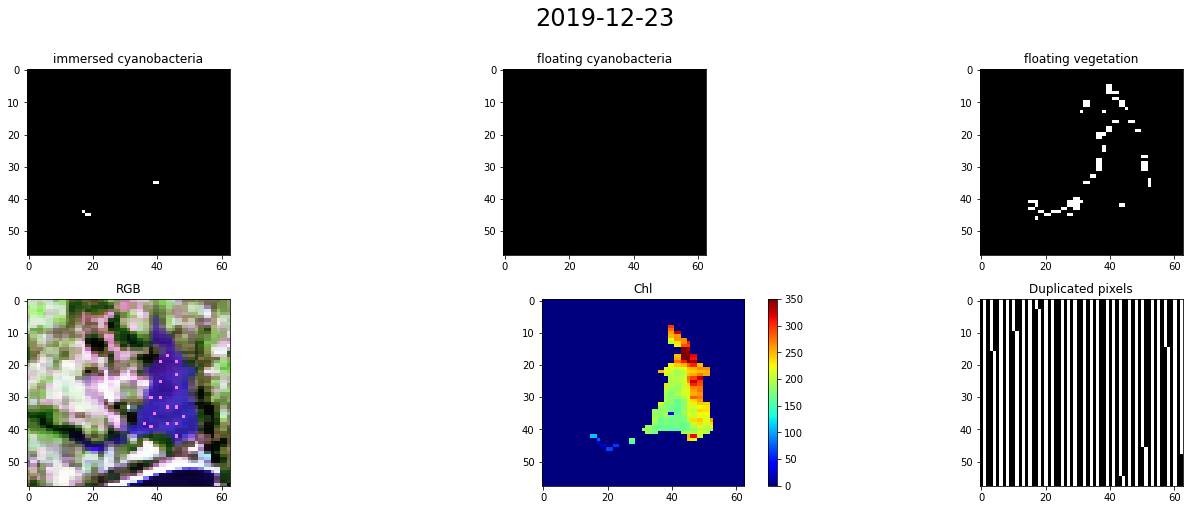

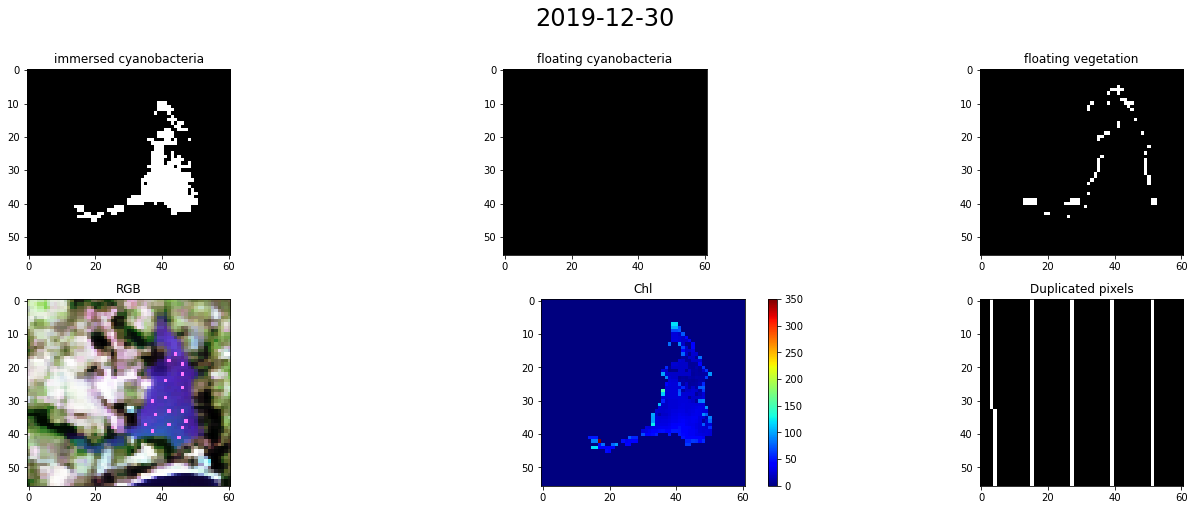

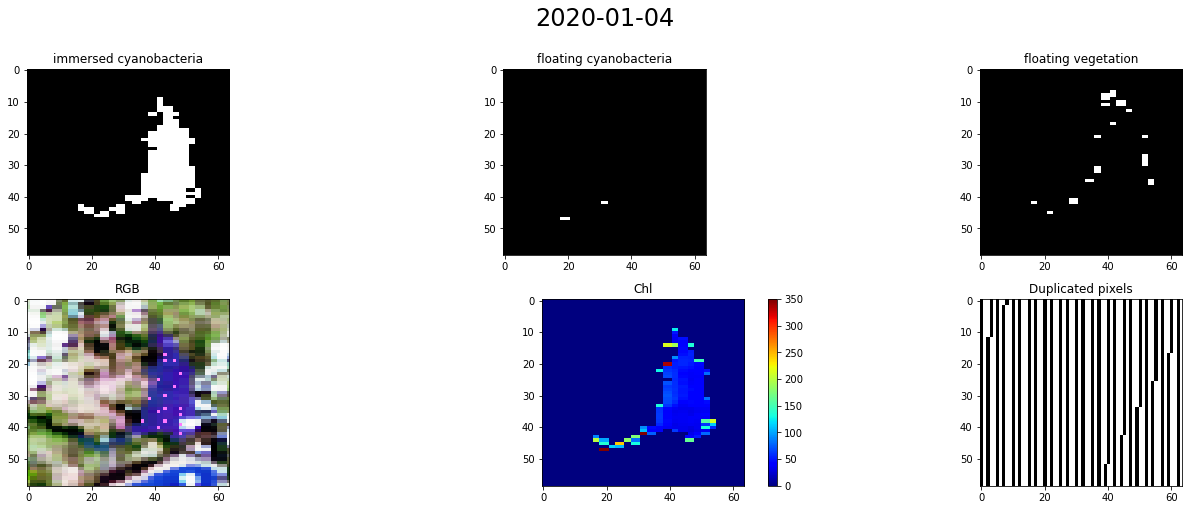

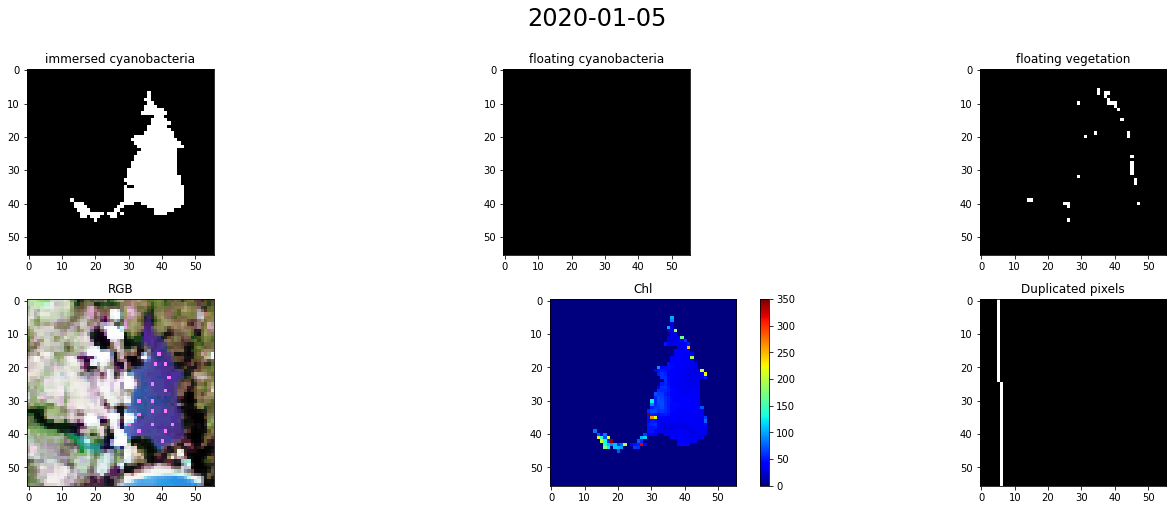

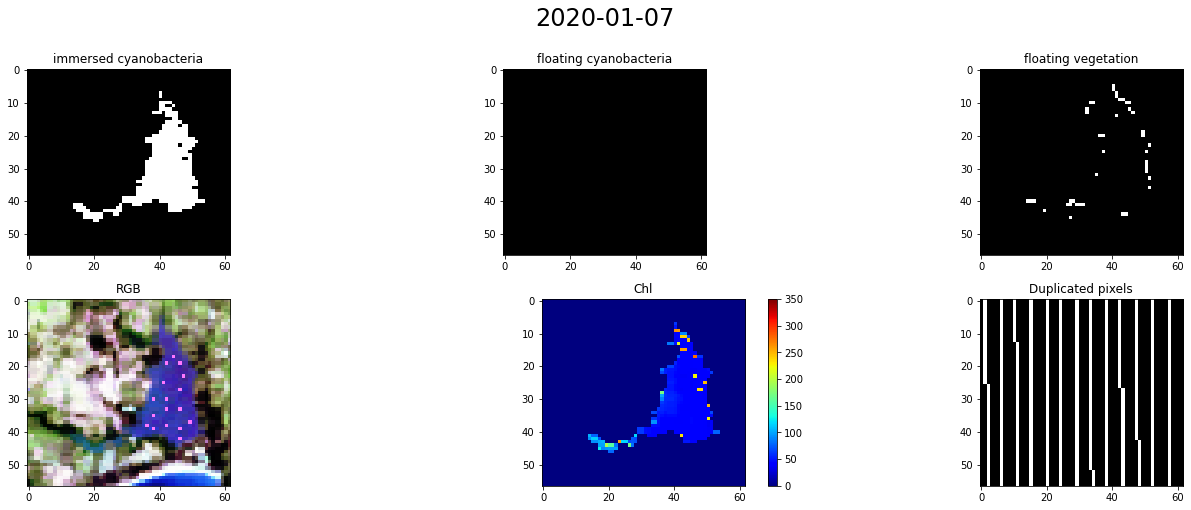

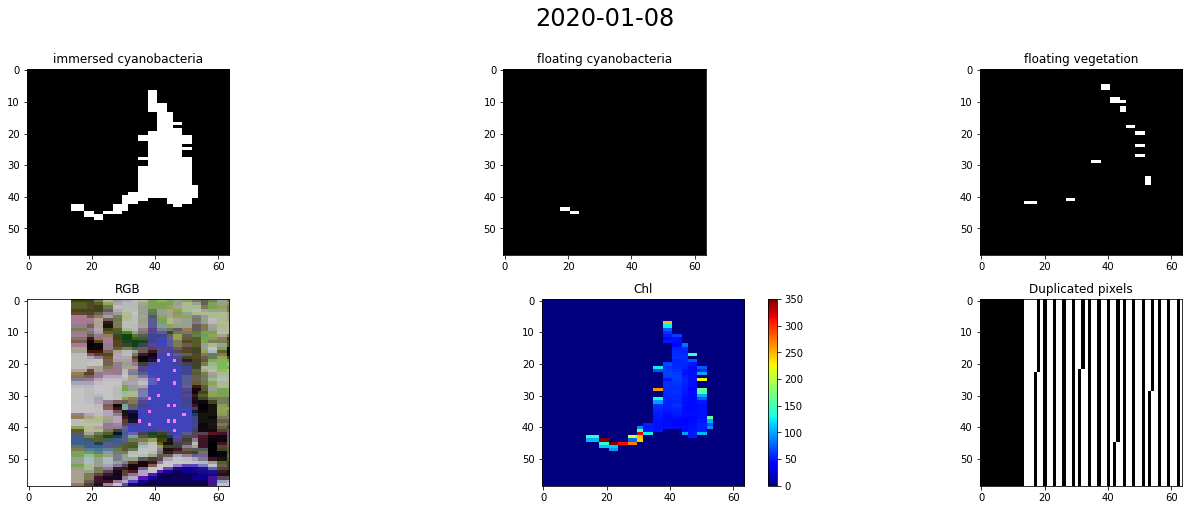

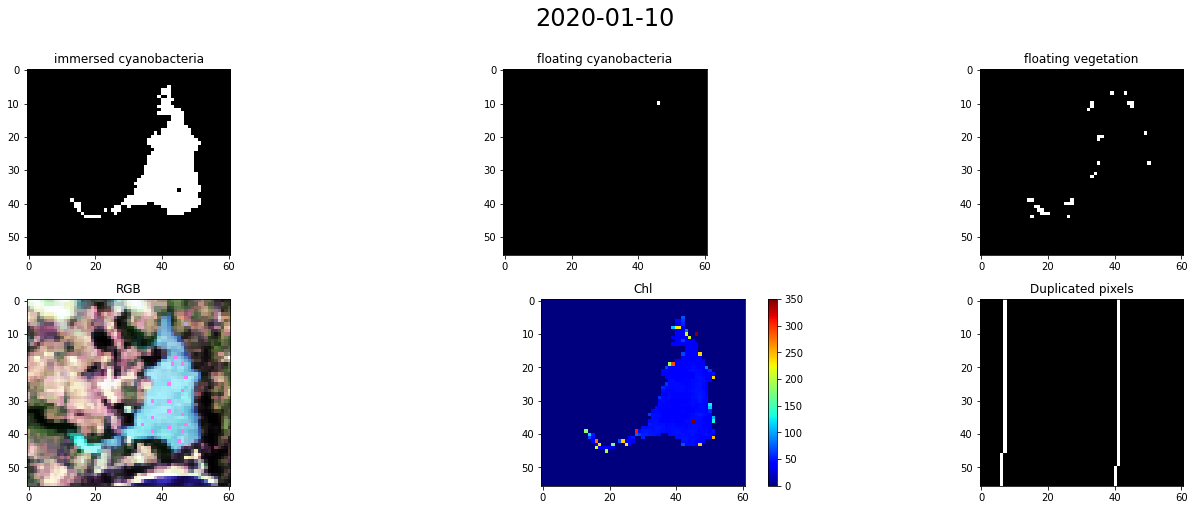

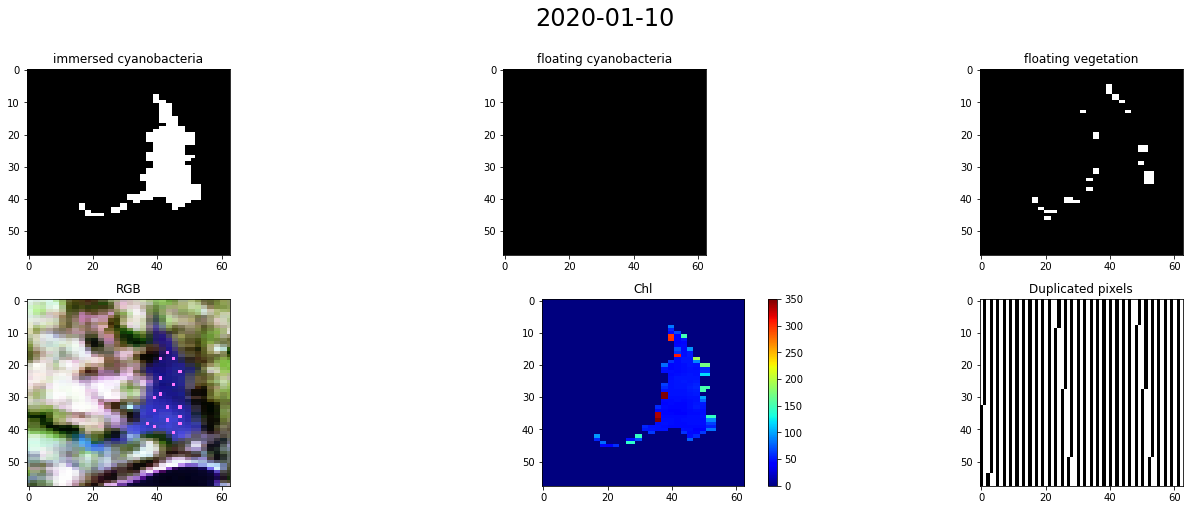

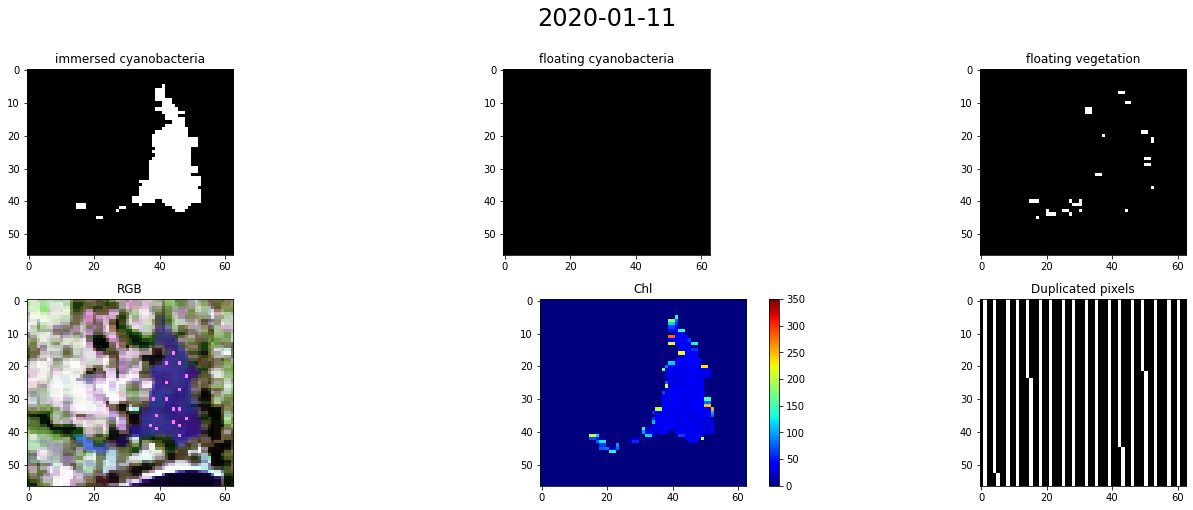

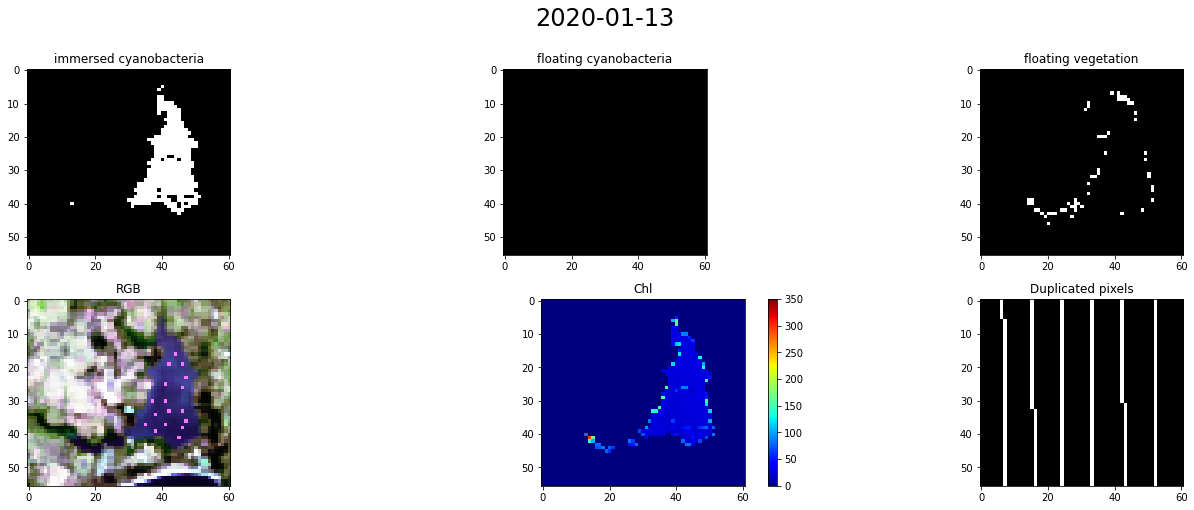

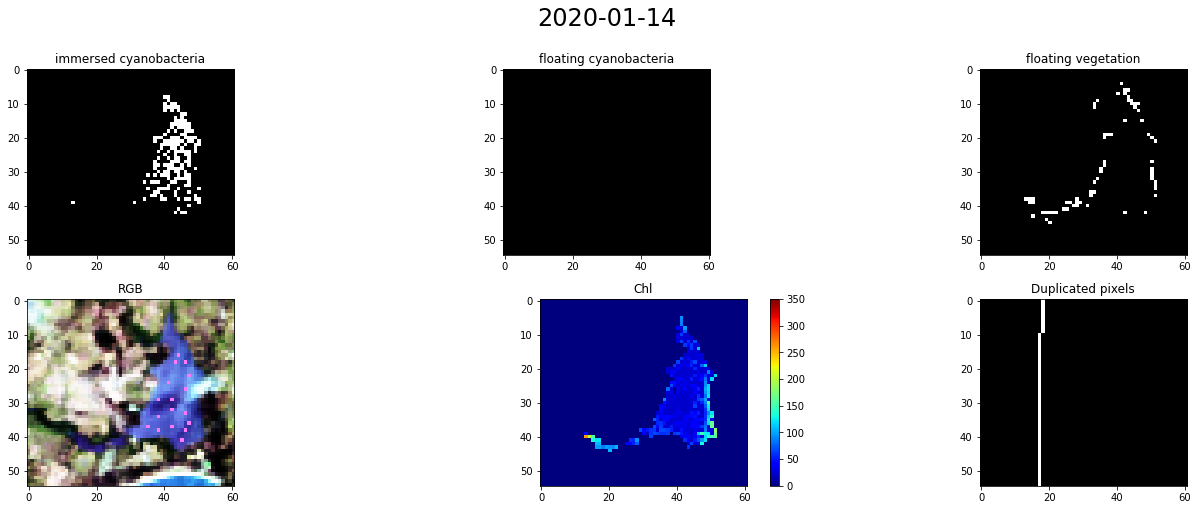

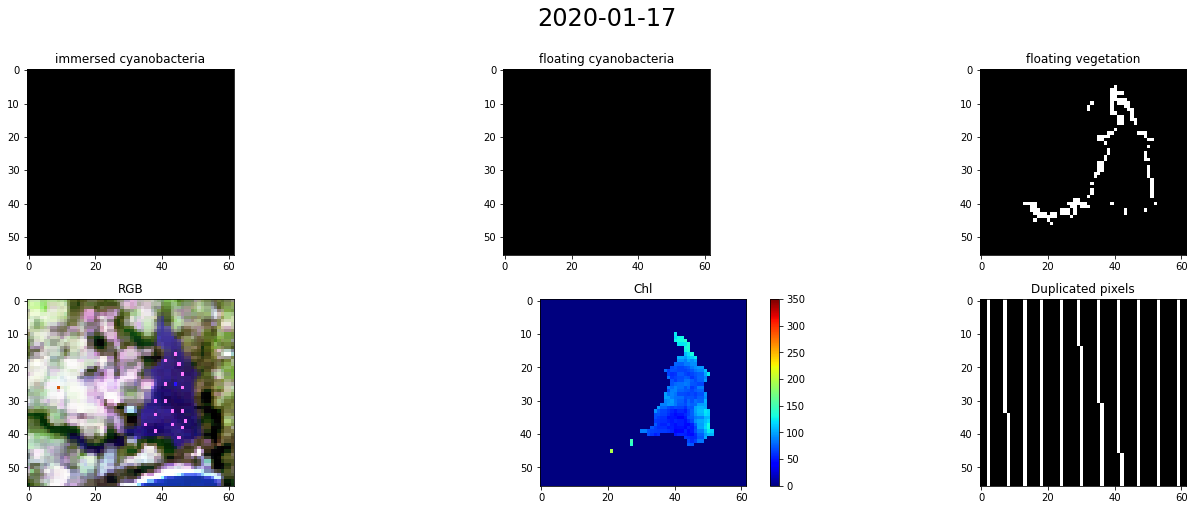

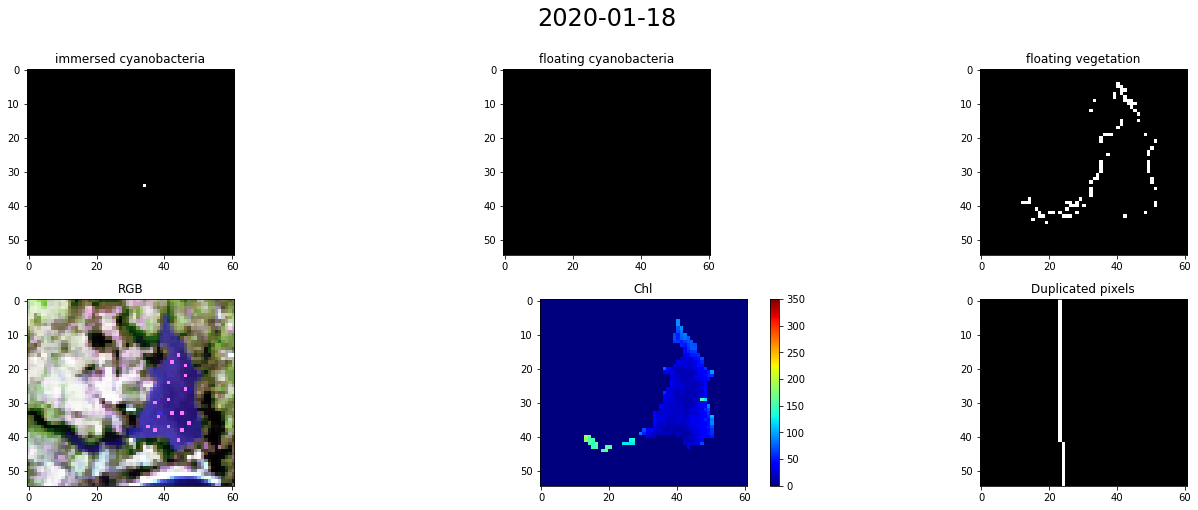

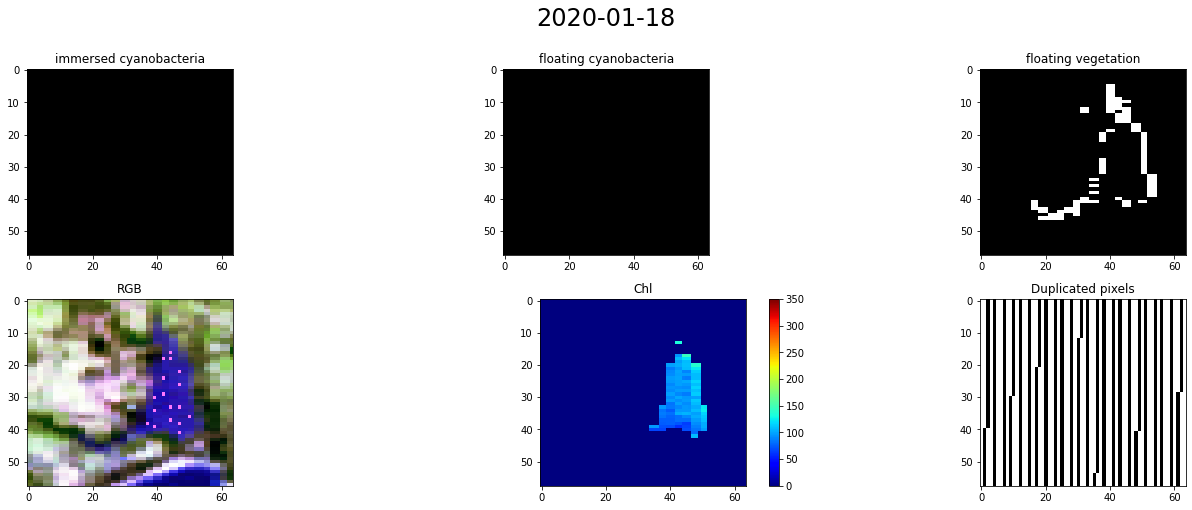

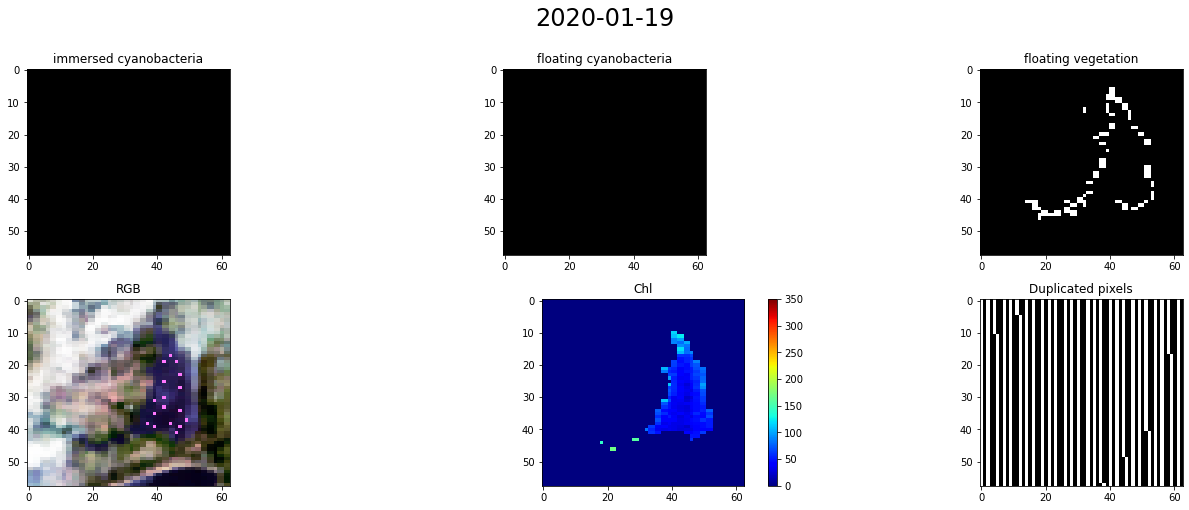

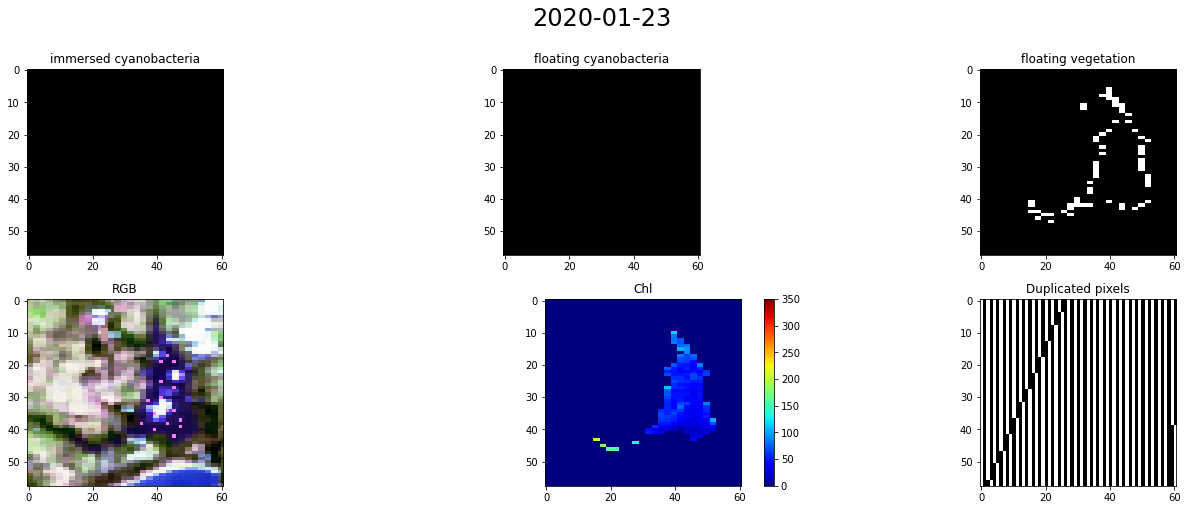

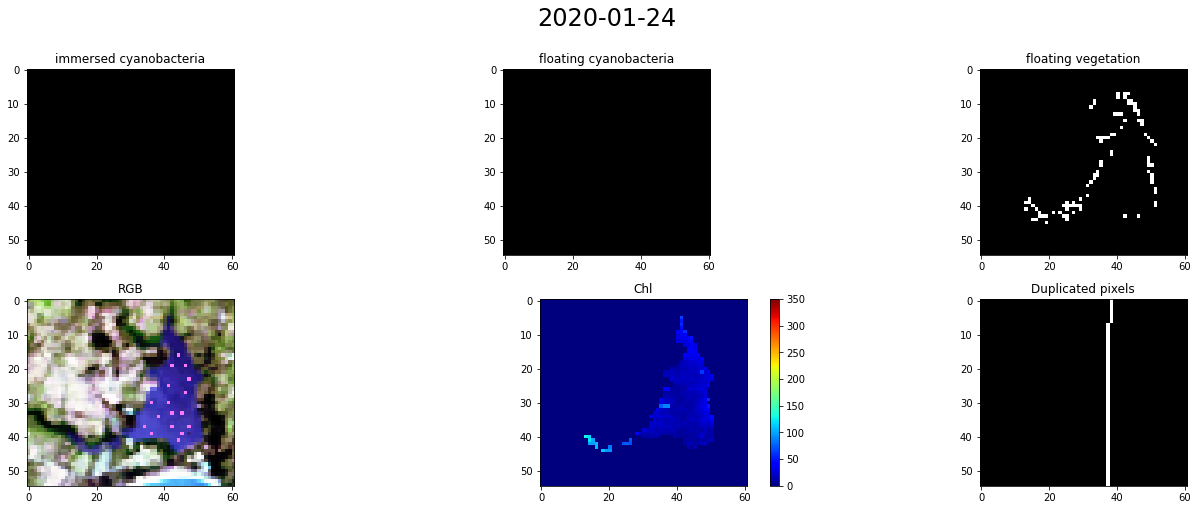

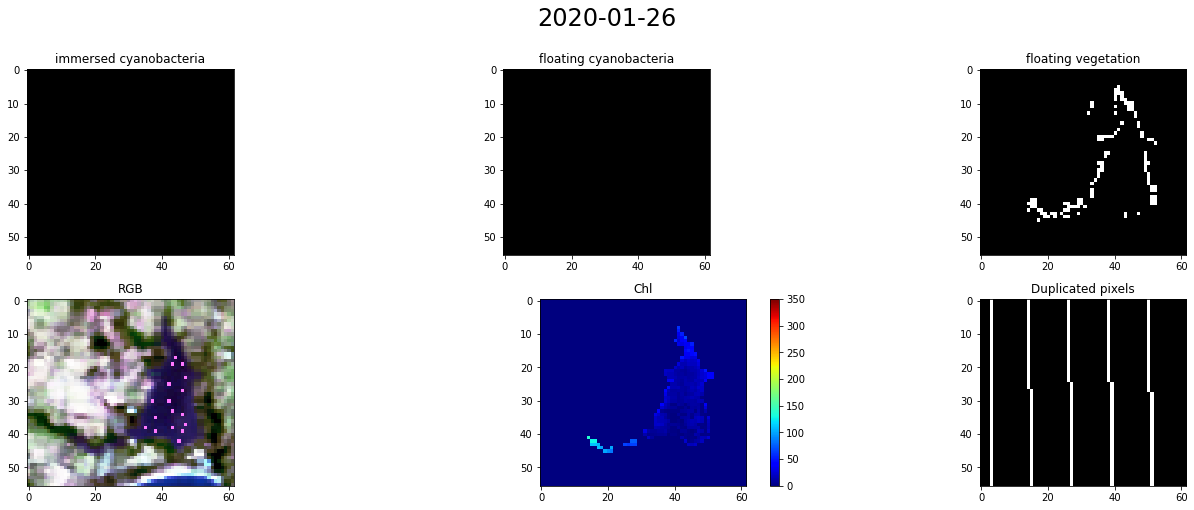

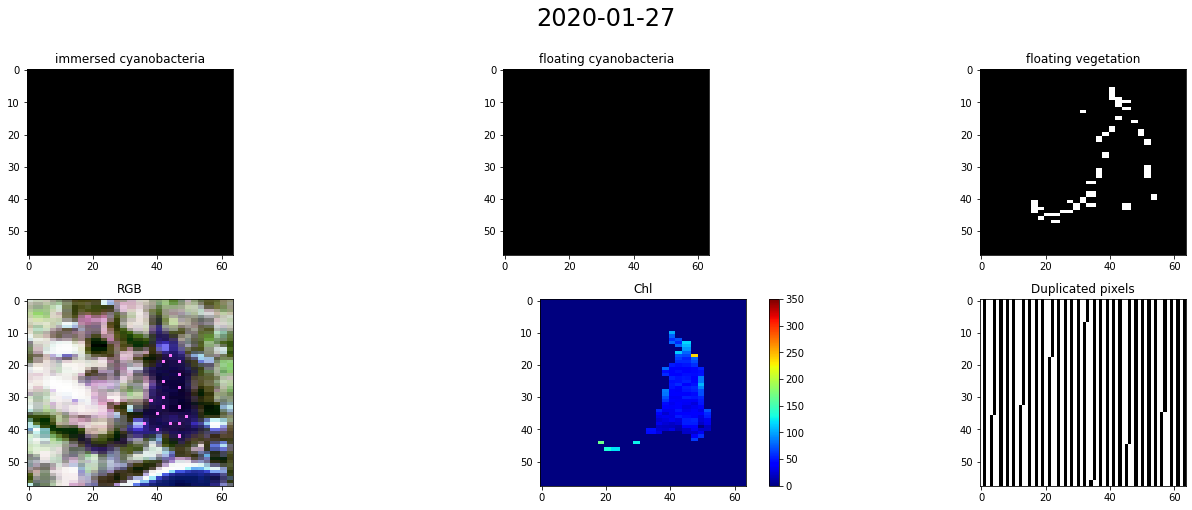

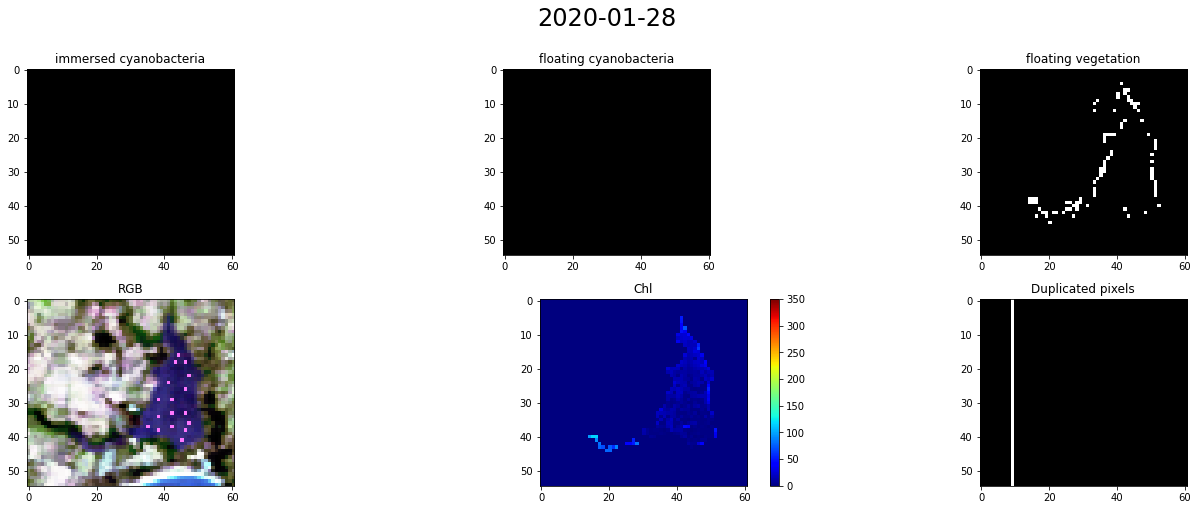

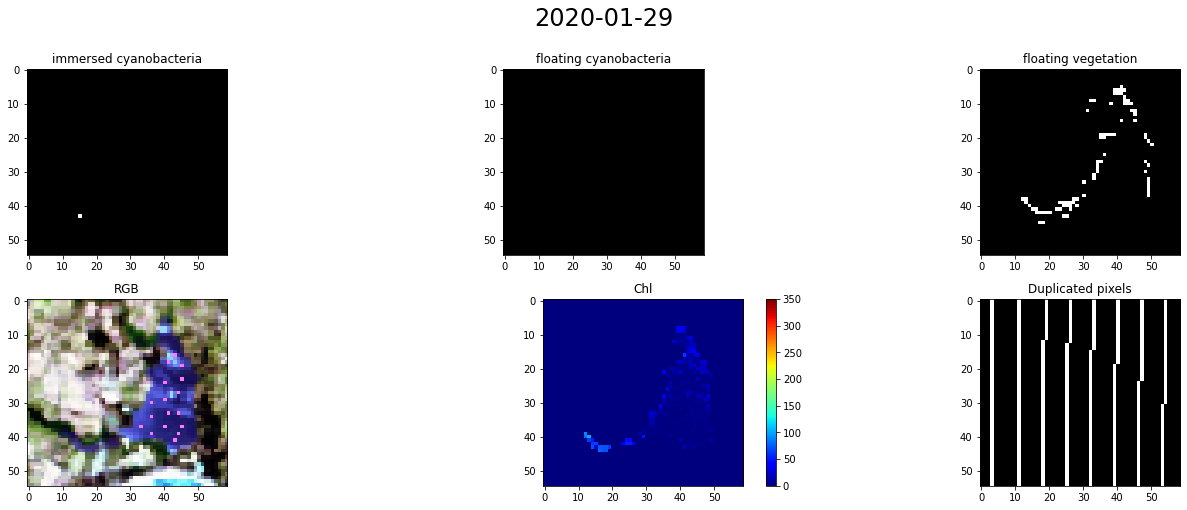

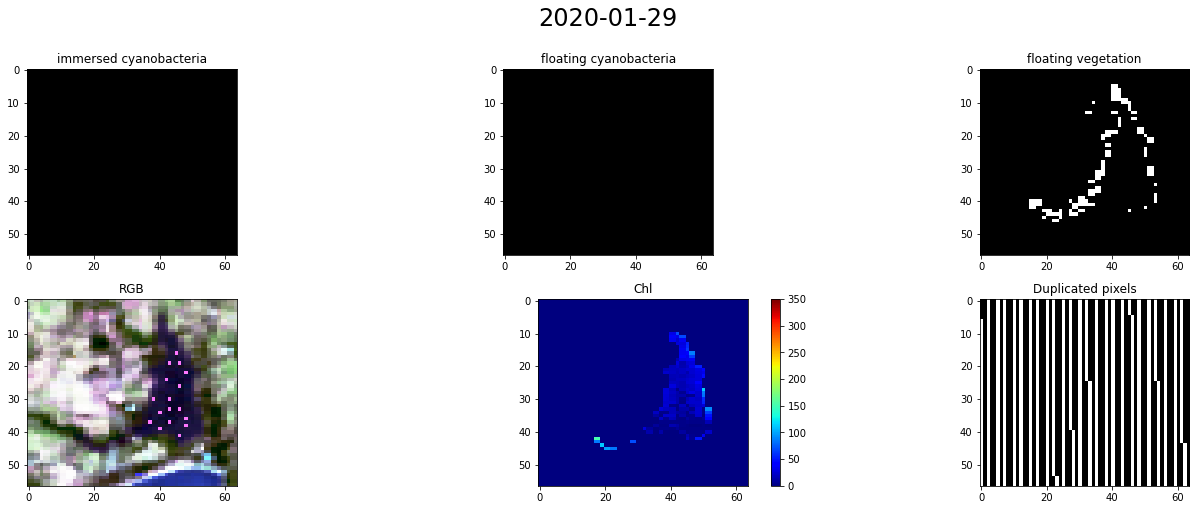

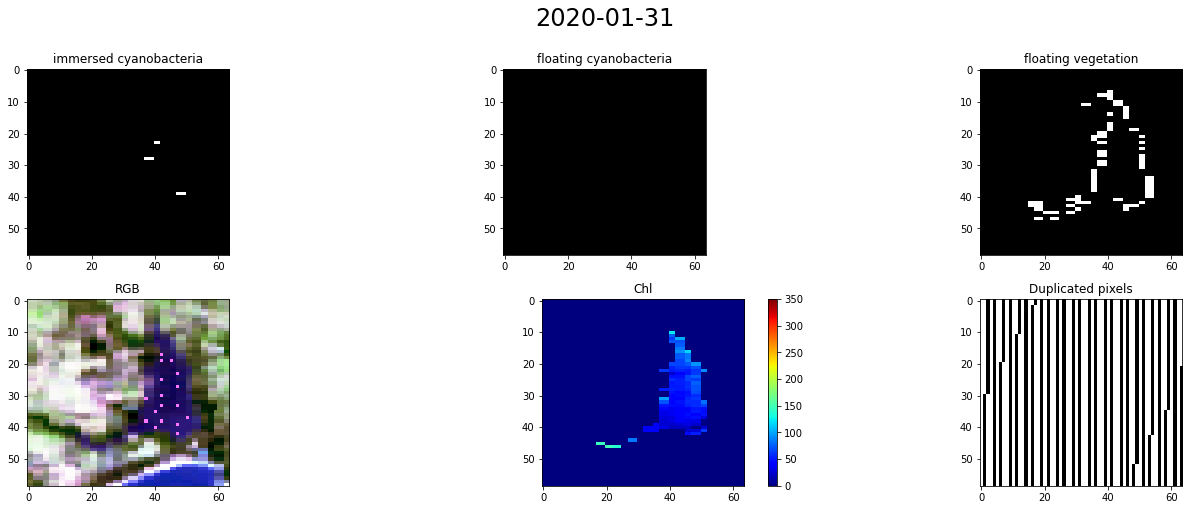

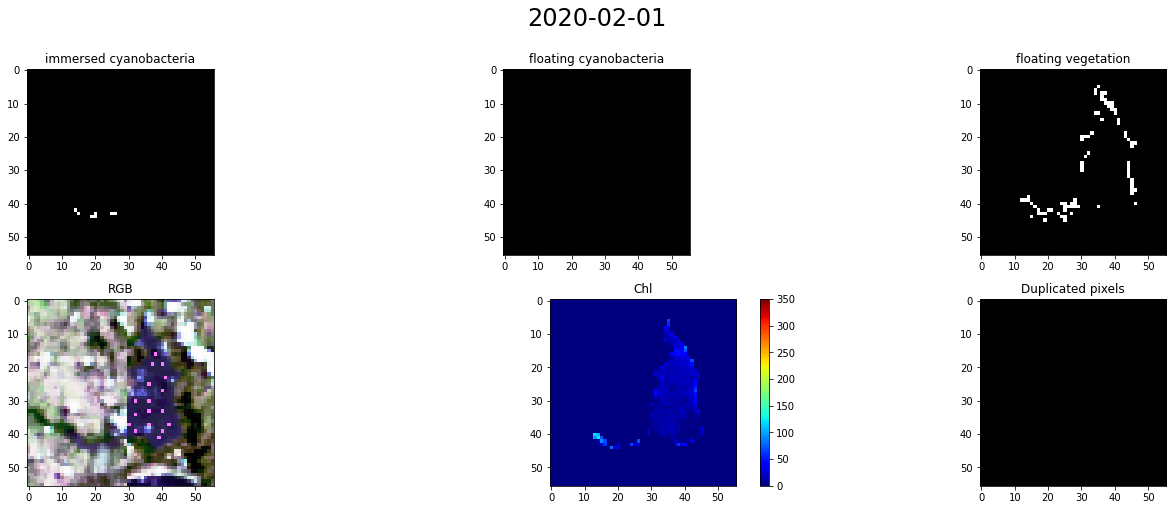

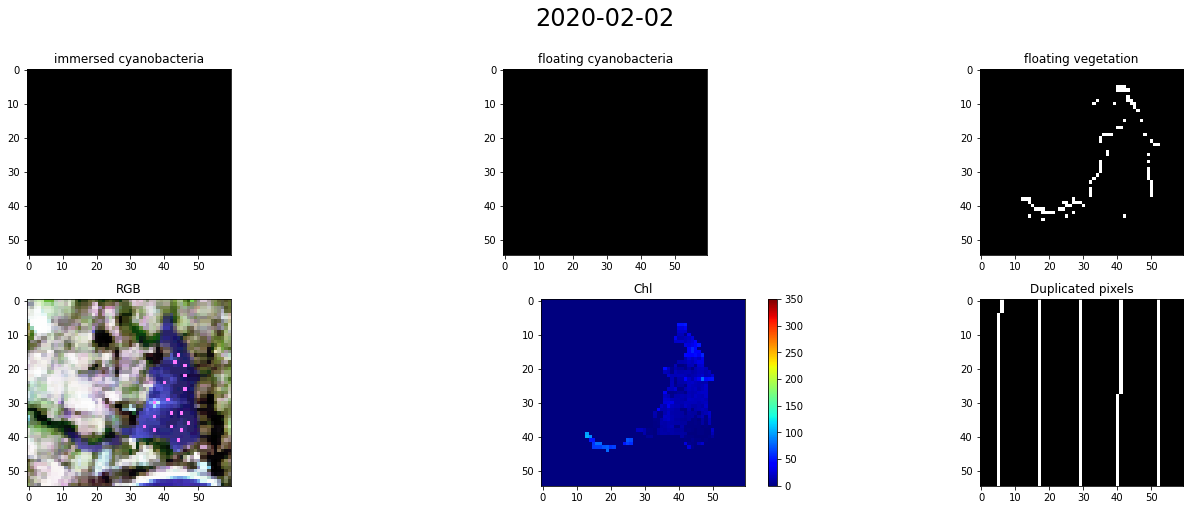

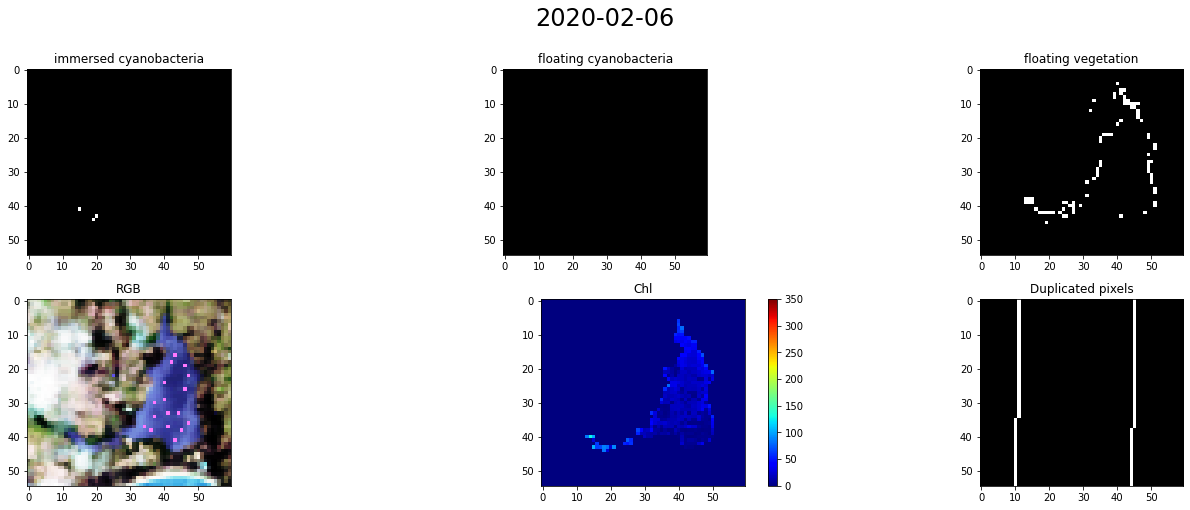

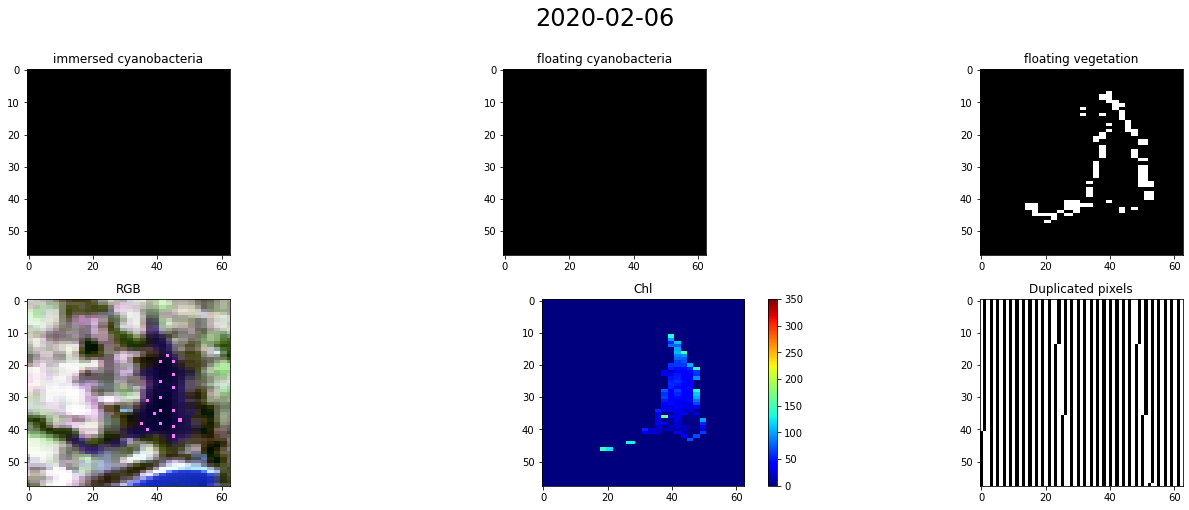

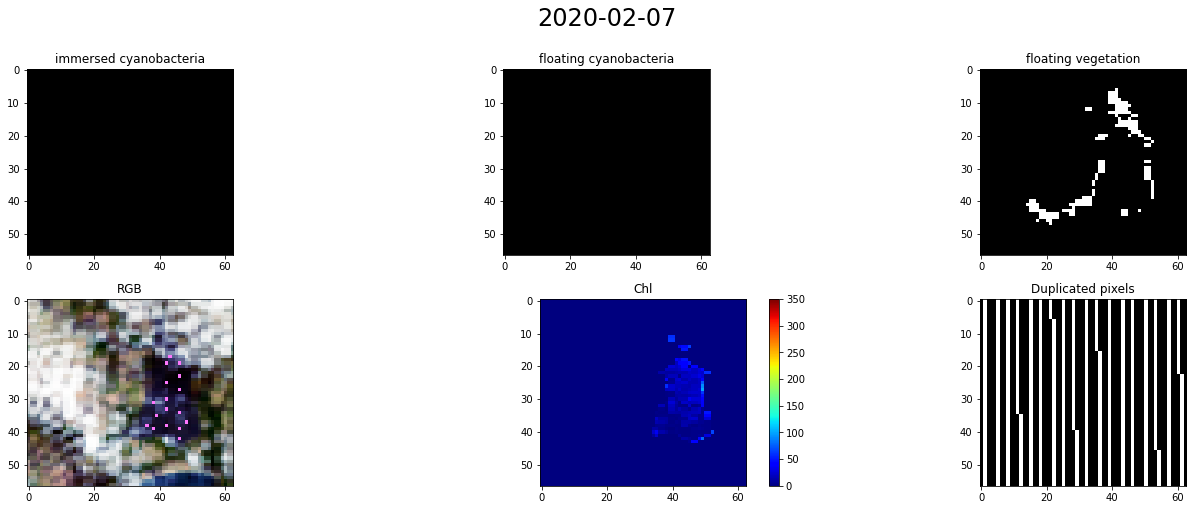

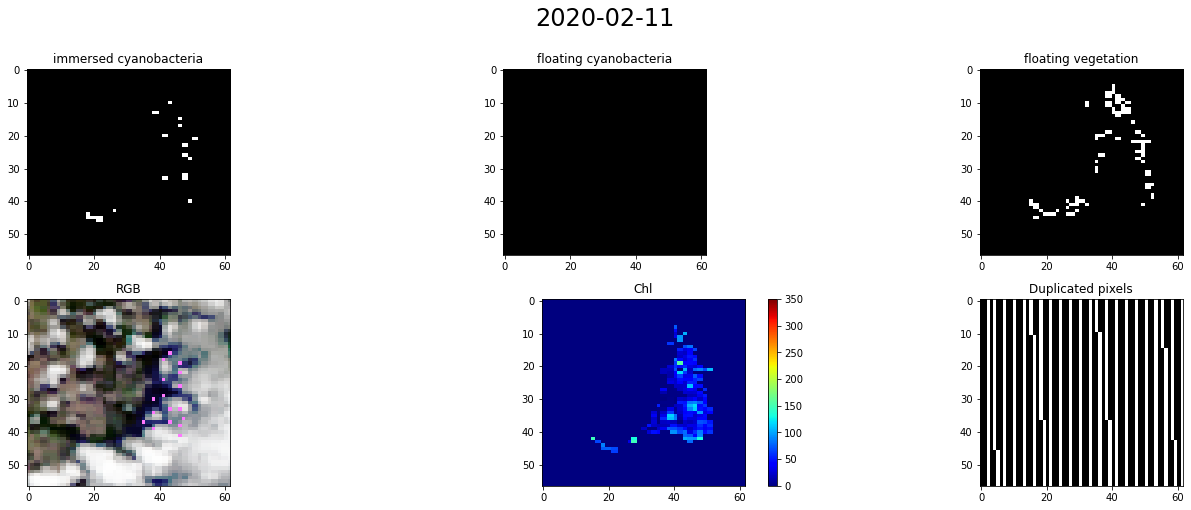

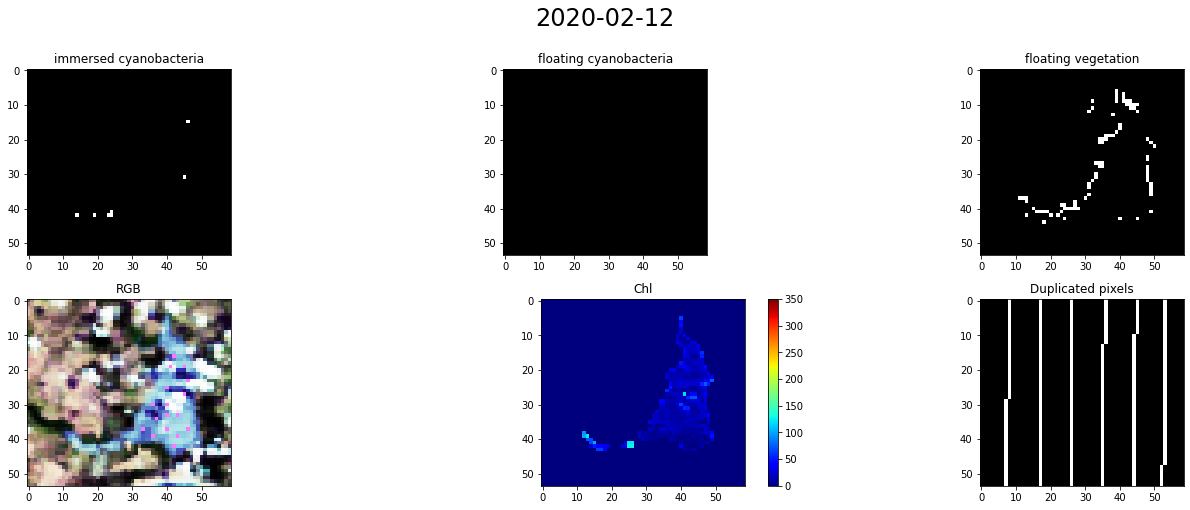

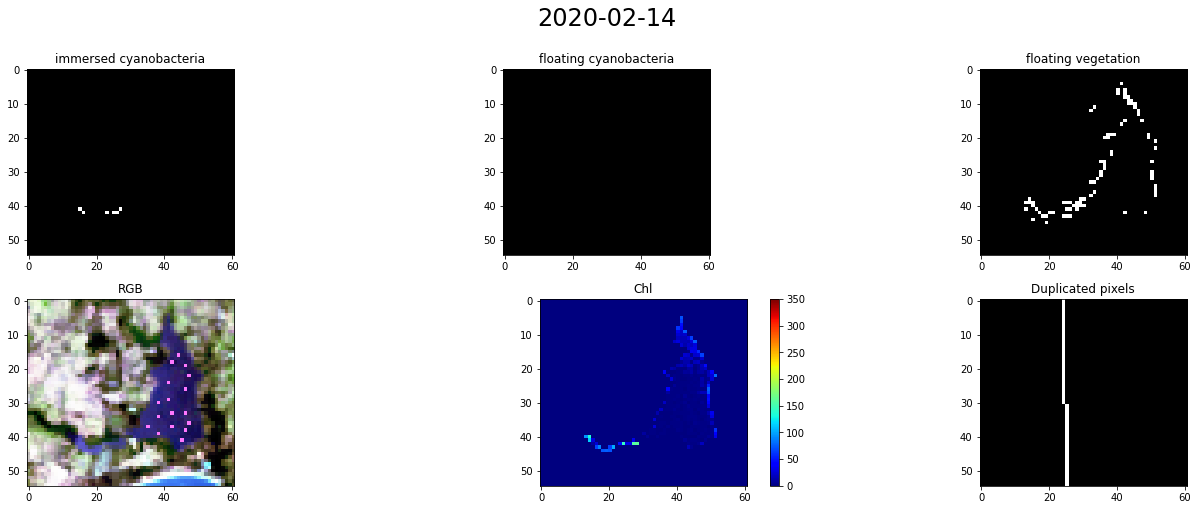

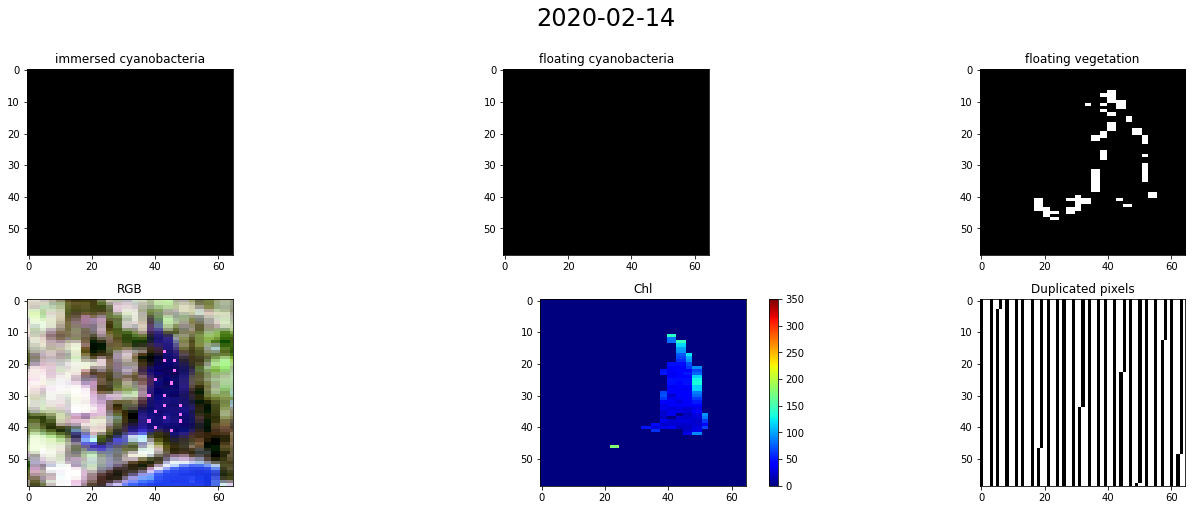

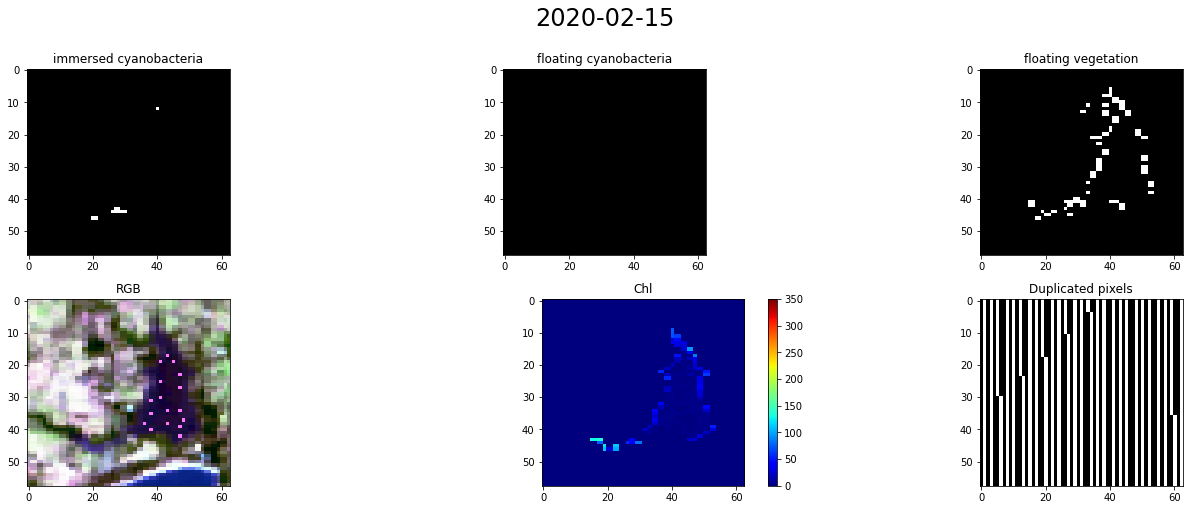

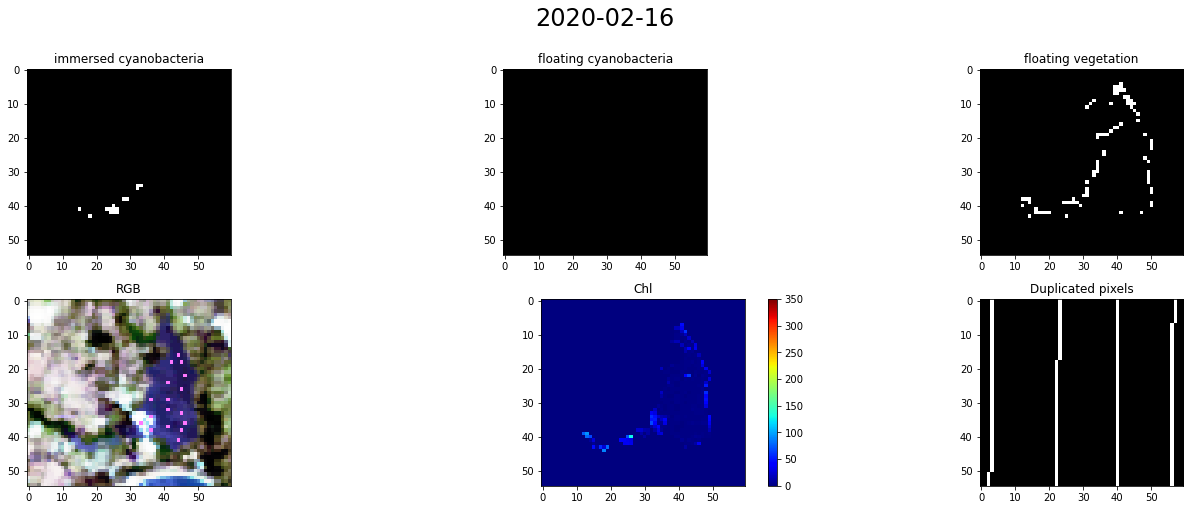

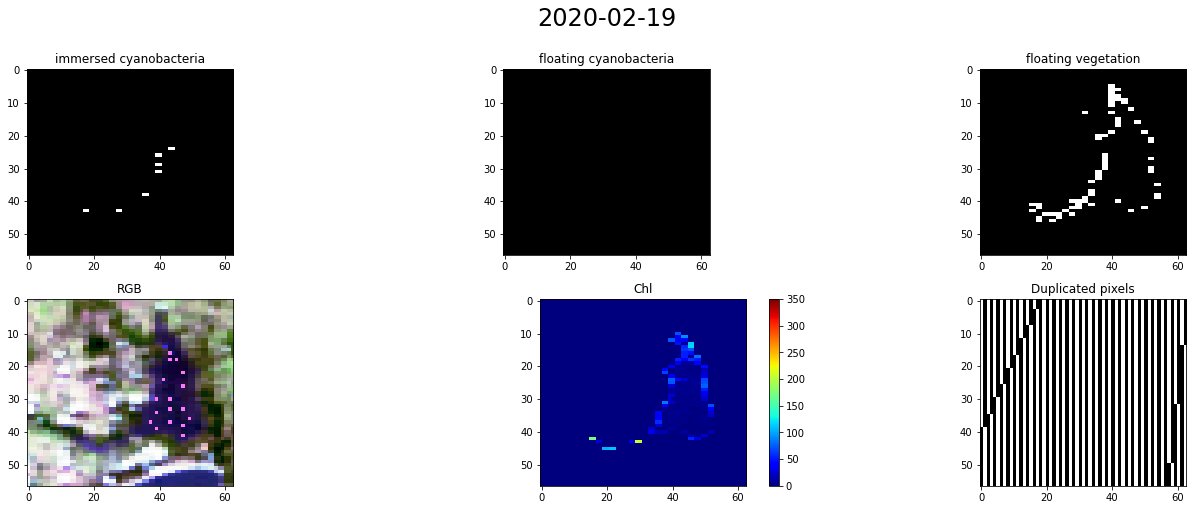

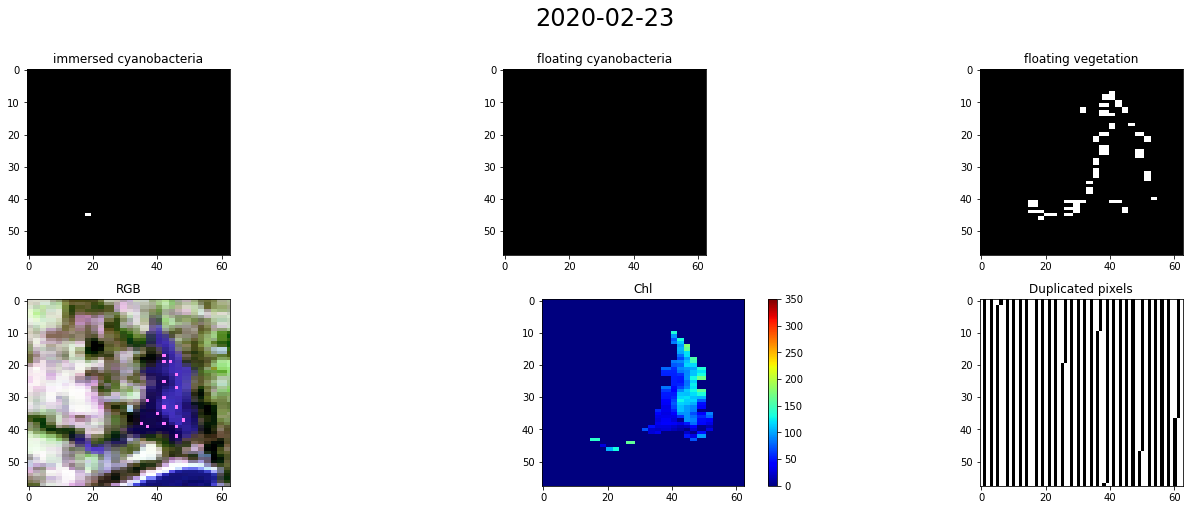

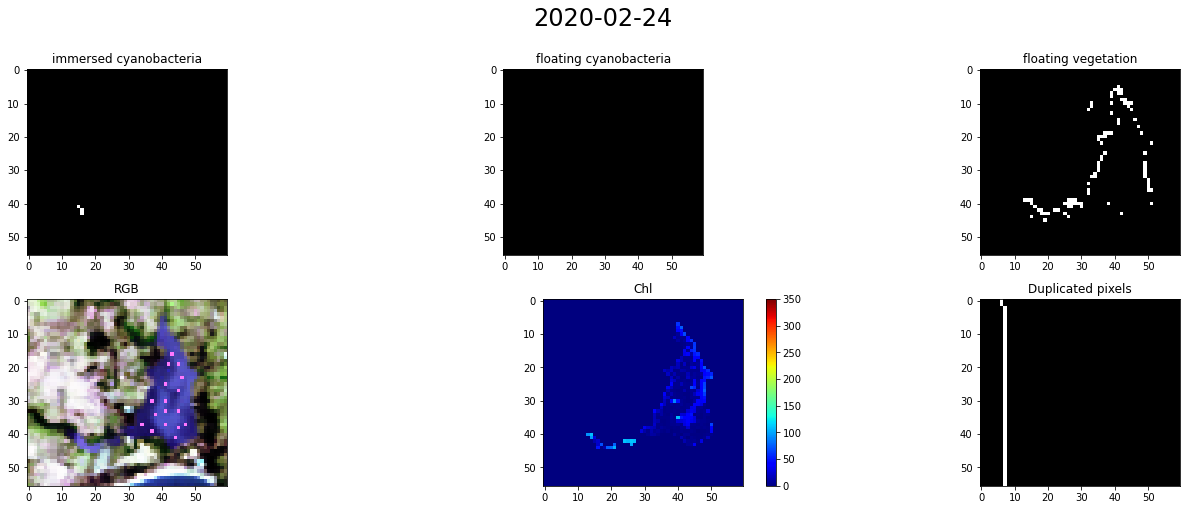

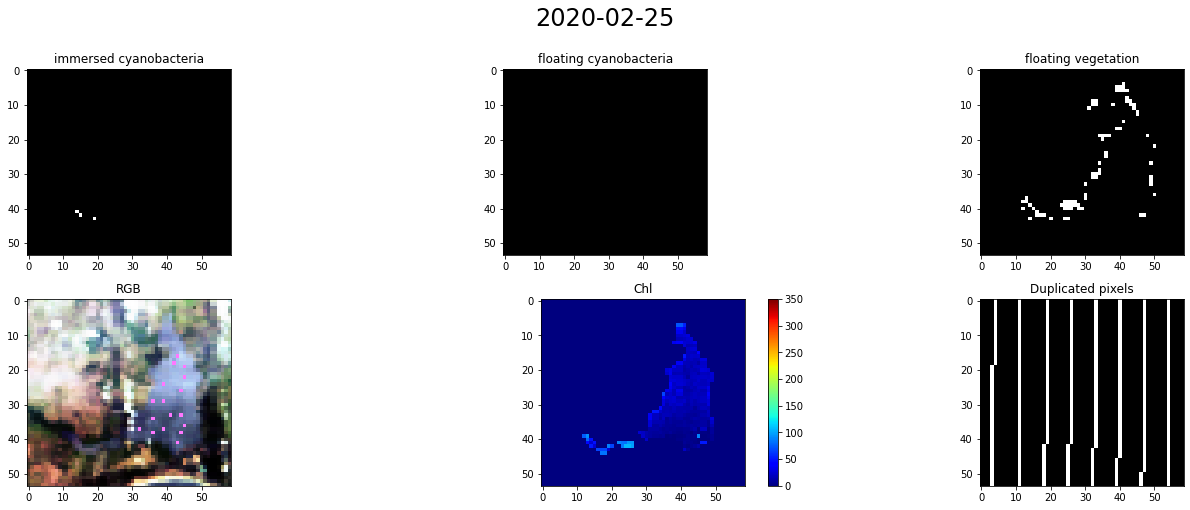

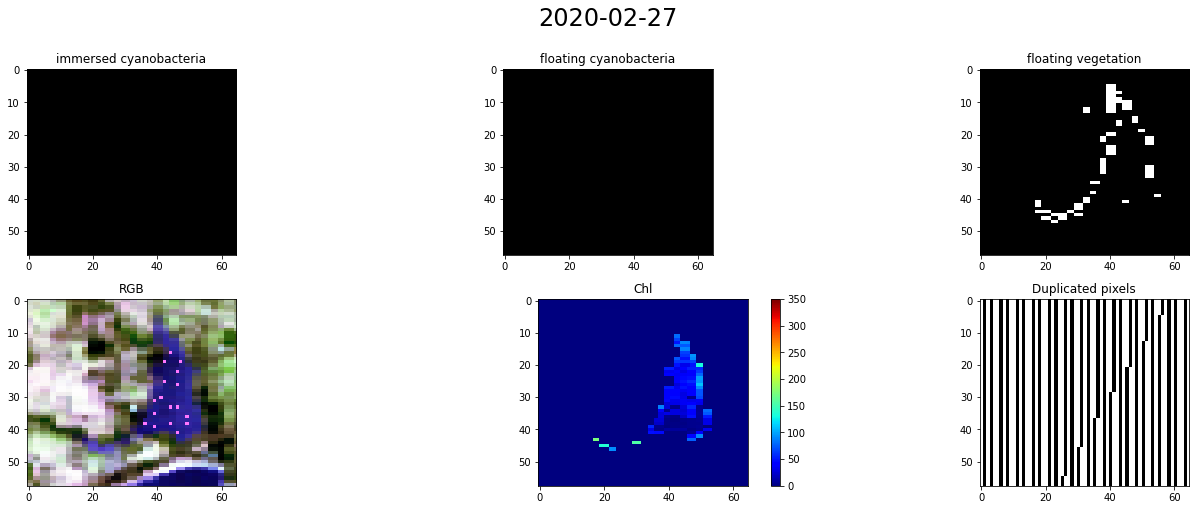

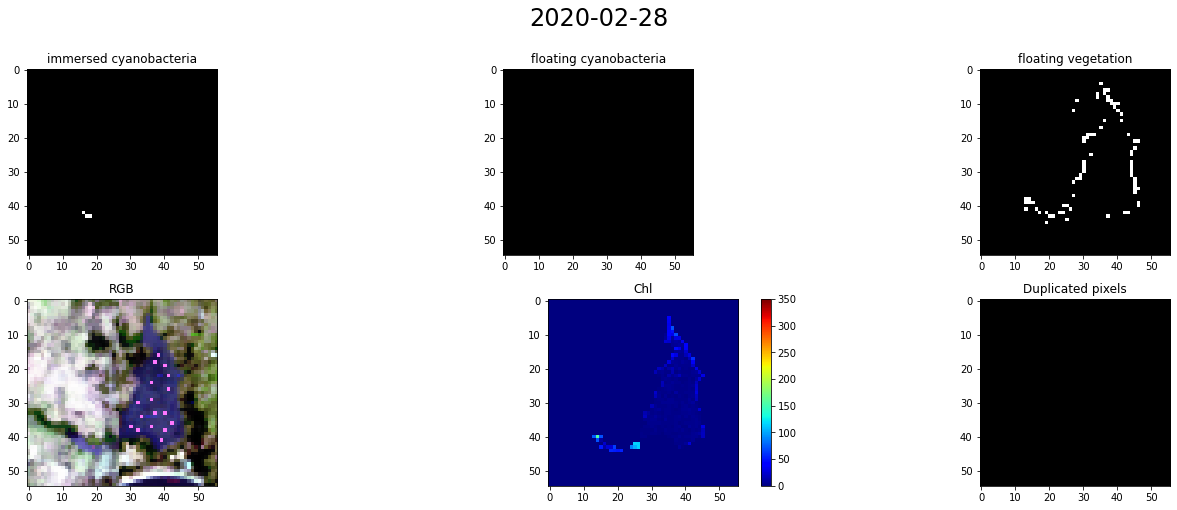

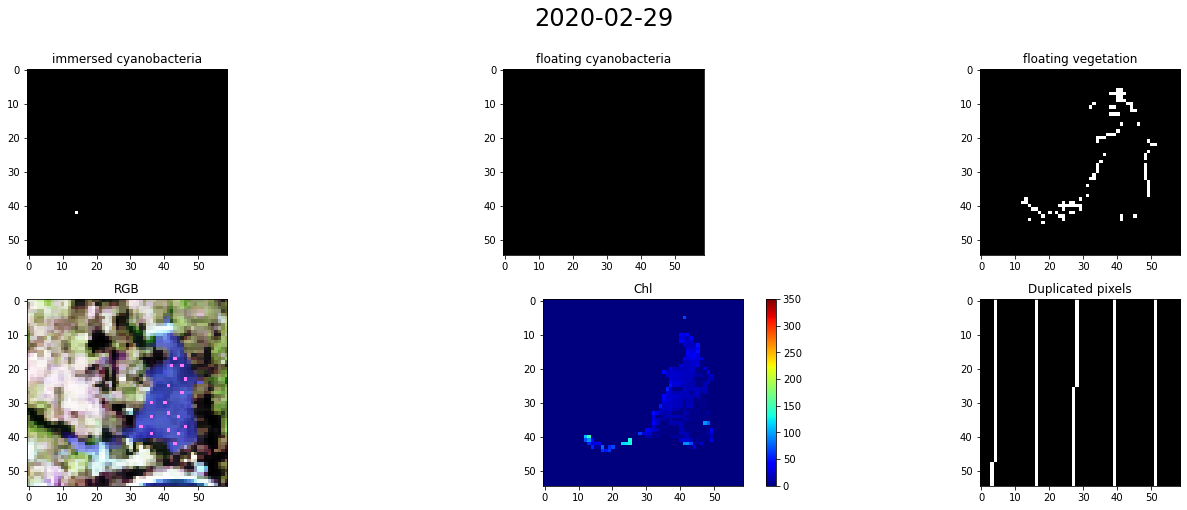

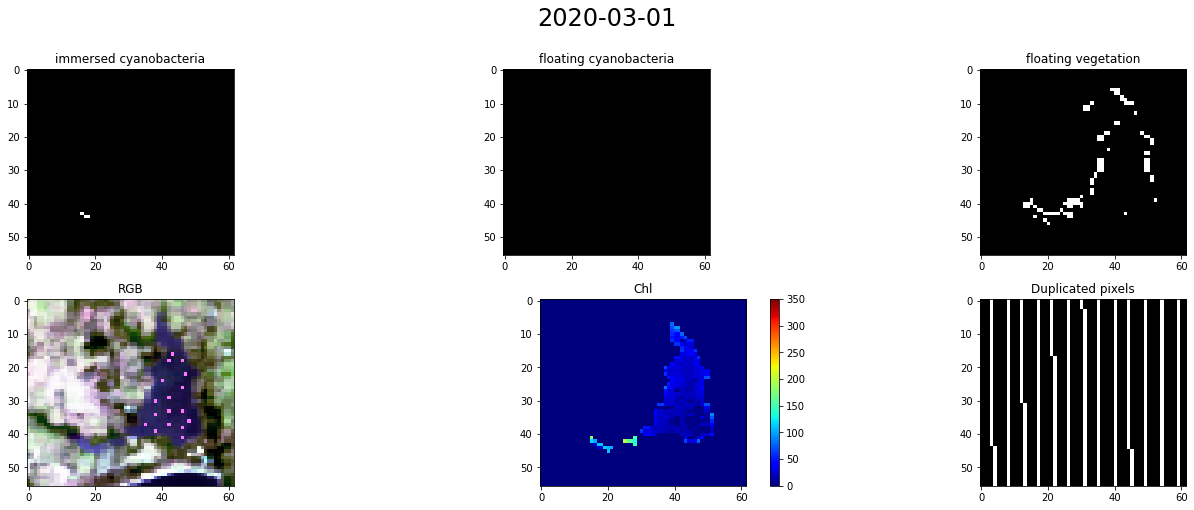

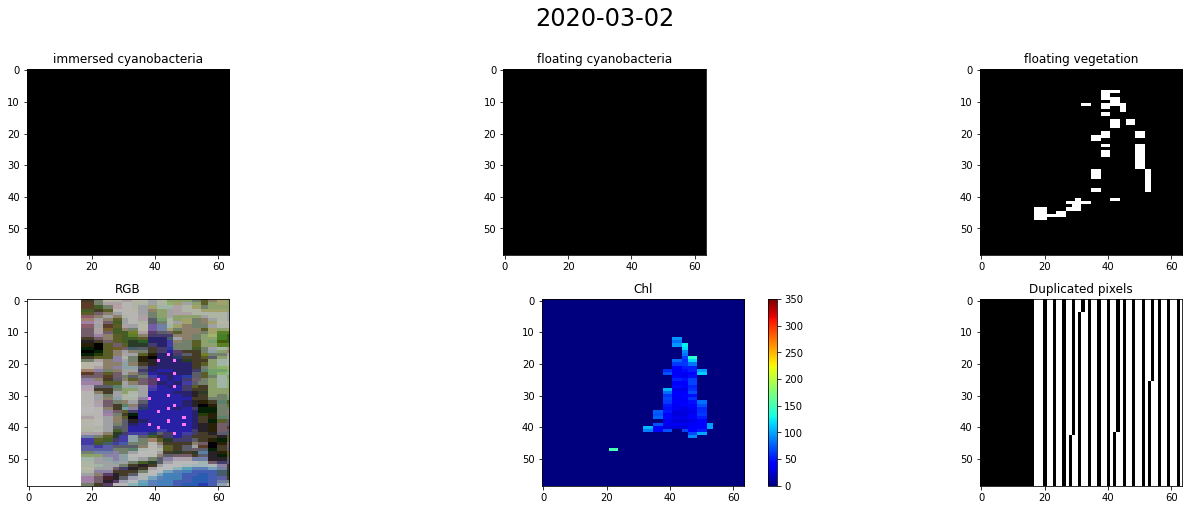

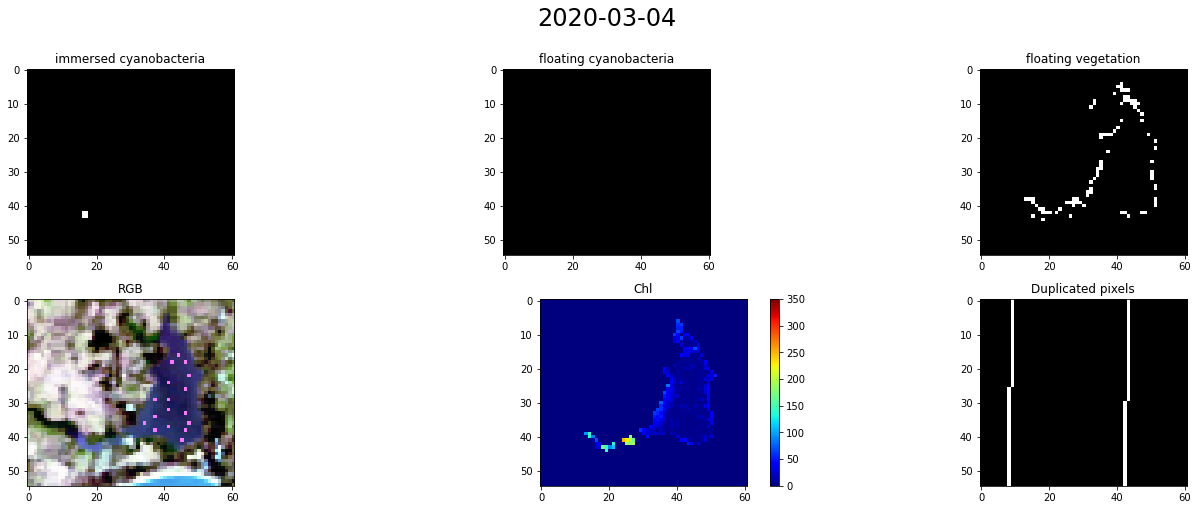

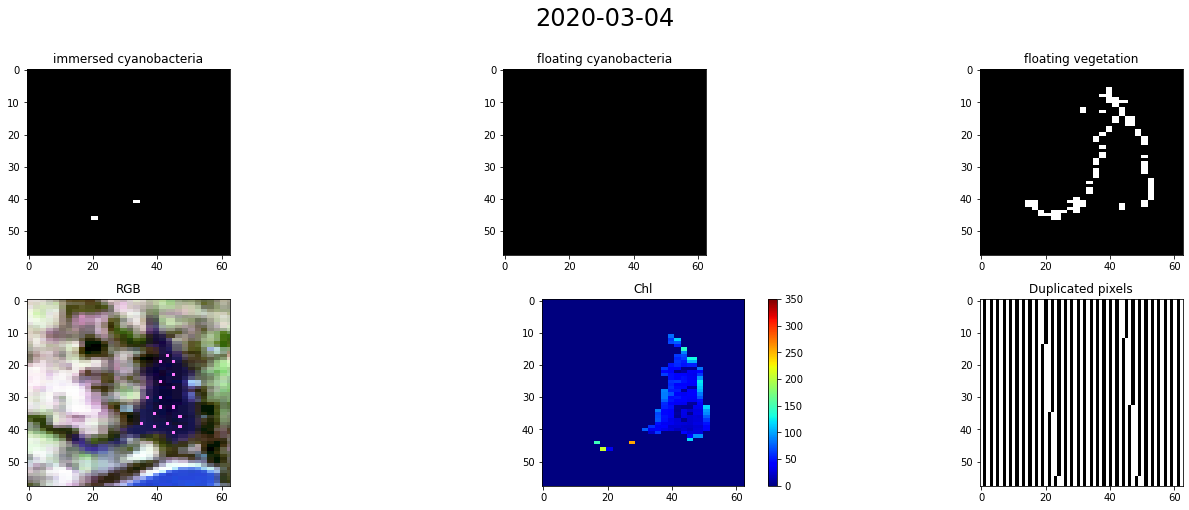

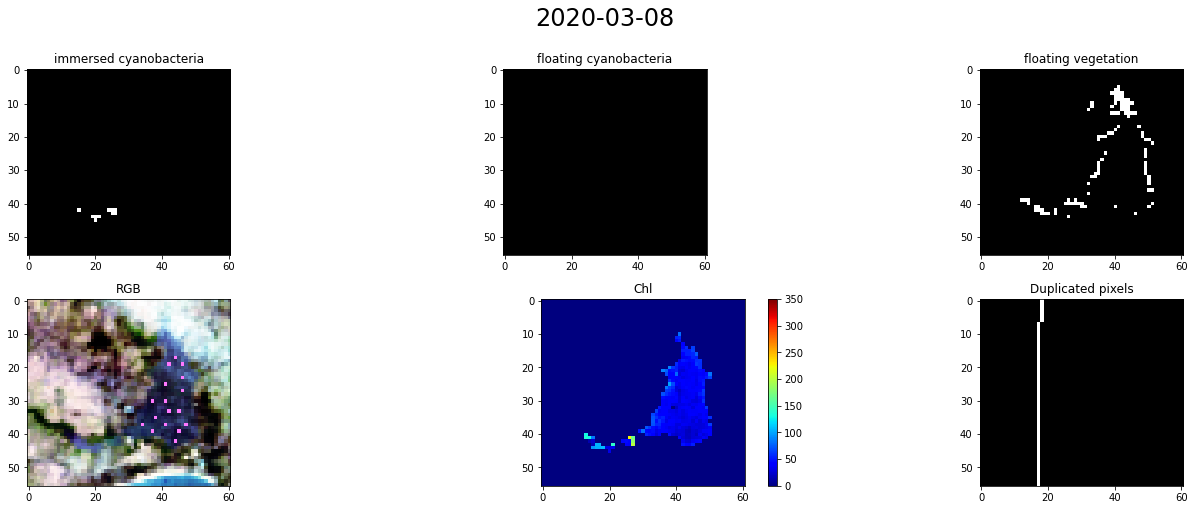

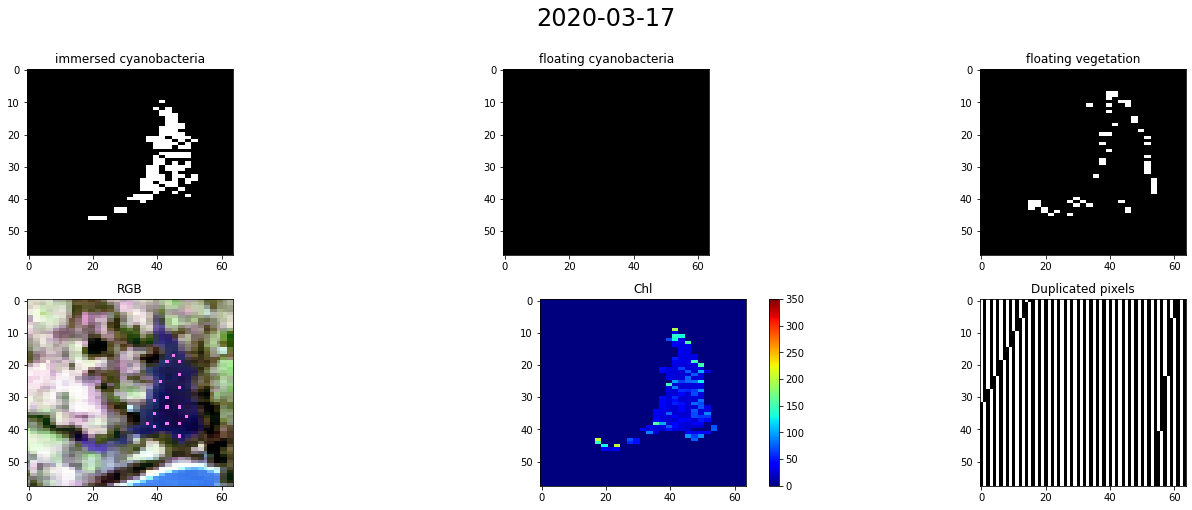

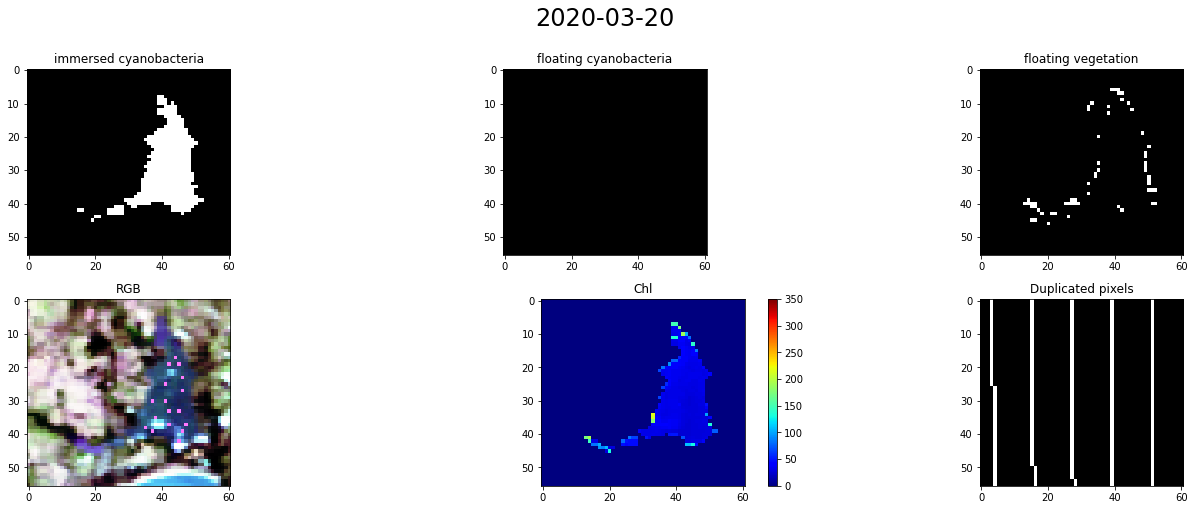

In [92]:
for day in clear_data:
    print(day.date.date())
    fig2 = plt.figure(figsize=(20,10))
    
    fig2.add_subplot(331).title.set_text("immersed cyanobacteria")
    plt.imshow(day.mph.immersed_cyanobacteria*day.water_mask, cmap="gray")
    
    fig2.add_subplot(332).title.set_text("floating cyanobacteria")
    plt.imshow(day.mph.floating_cyanobacteria*day.water_mask, cmap="gray")
    
    fig2.add_subplot(333).title.set_text("floating vegetation")
    plt.imshow(day.mph.floating_vegetation*day.water_mask, cmap="gray")
    
    fig2.add_subplot(334).title.set_text("RGB")
    day.paint_coords(CONTROL_COORDS, [255, 119, 255])
    plt.imshow(day.rgb)
    
    fig2.add_subplot(335).title.set_text("Chl")
    plt.imshow(day.mph.chl*day.water_mask*np.logical_not(day.mph.floating_vegetation), cmap='jet', interpolation='none',
              vmin=0, vmax=350)
    plt.colorbar()
    
    fig2.add_subplot(336).title.set_text("Duplicated pixels")
    plt.imshow(day.duplicated, cmap='gray')
    
    fig2.suptitle(str(day.date.date()), fontsize=24, y=1)
    fig2.tight_layout()
    plt.savefig(os.path.join("verano2020-2", str(day.date.date()) + ".png"))

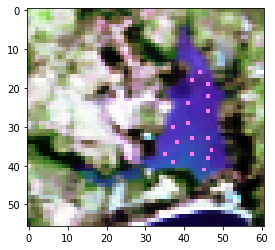

In [91]:
clear_data[1].paint_coords(CONTROL_COORDS, [255, 119, 255])
plt.imshow(clear_data[1].rgb)